# Includes:

In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sn
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from data_paths import get_file_paths_ordered
from tf_lite_conversion import convert_to_tf_lite, eval_tf_lite_model
from scipy.io import wavfile
from IPython.display import Audio
from pre_process import choose_tot_slice_len, get_data_tensors, compute_mfccs
from qkeras import *

In [2]:
# Number of speakers and the percentage of the available samples to use to consider:
num_speakers = 5
model_name = 'test_' + str(num_speakers) + '_spk'
dataset_percentage = 1. # 0.85
segmentLength=1024
print("Number of speakers : ", num_speakers)

Number of speakers :  5


In [3]:
model_dir_root = './Models/'+ f'{model_name}/'


path_qkeras_model = model_dir_root + 'QKerasModels/'
path_qkeras_biased_model = model_dir_root + 'Biased_QKerasModels/'
path_tflite_qkeras = model_dir_root + 'TFLiteQKeras/'
path_figures = model_dir_root + 'Figures/'

# Create the directories
paths = [path_qkeras_model, path_tflite_qkeras, path_figures]

for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

print('Models will be saved to: ', model_dir_root)

model_name_qkeras = 'qkeras_' + model_name + '.h5'
model_name_biased_qkeras = 'biased_qkeras_' + model_name + '.h5'
model_name_tf_lite_qkeras = 'tfflite_qkeras_' + model_name + '.tflite'
model_name_tf_lite_biased_qkeras = 'tfflite_biased_qkeras_' + model_name + '.tflite'

Models will be saved to:  ./Models/test_5_spk/


In [4]:
paths_train, paths_test, y_train_l, y_test_l, all_paths_l = \
    get_file_paths_ordered(num_speaker=num_speakers, test_ratio=0.2, balanced_dataset=False)

slice_len, durations = choose_tot_slice_len(paths=all_paths_l)

Total number of speakers in the original dataset: 25
Number of speakers that will be used for training:5 => 20.0%
Original number of files:  3306
Training number of files : 2644 => 79.97580157289777%
Visualization of the samples ...


100%|██████████| 3306/3306 [00:00<00:00, 10770.12it/s]


In [5]:
slice_len, durations = choose_tot_slice_len(paths=all_paths_l)

with tf.device("/cpu:0"):
    f_s, x_train, y_train, x_test, y_test = get_data_tensors(paths_train=paths_train, paths_test=paths_test, 
                                                            y_train_l=y_train_l, y_test_l=y_test_l,
                                                            tot_slice_len=slice_len,
                                                            used_train_sz_rat=dataset_percentage, 
                                                            used_test_sz_rat=1.,
                                                            segmentLength=segmentLength)
print("Train - test size before feature extraction : ", x_train.shape, x_test.shape)

Visualization of the samples ...


100%|██████████| 662/662 [00:00<00:00, 770.41it/s]


Train - test size before feature extraction :  (2644, 171, 1024) (662, 171, 1024)


# Pre-Processing:

In [6]:
f_low=80.
f_up=7600.
num_mel_bins=80
num_mfcc=13
segmentLength=1024

with tf.device("/cpu:0"):
    x_train_mfcc = compute_mfccs(x_train, frame_length=segmentLength, sample_rate=f_s, 
                                lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                                num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)
    x_test_mfcc  = compute_mfccs(x_test, frame_length=segmentLength, sample_rate=f_s, 
                                lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                                num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)

In [7]:
train_set = x_train_mfcc
test_set = x_test_mfcc
print("Train - test size after feature extraction : ", train_set.shape, test_set.shape)

Train - test size after feature extraction :  (2644, 171, 13, 1) (662, 171, 13, 1)


# QKeras Model


In [8]:
from models import get_qmodel
qmodel = get_qmodel(train_set.shape, num_speakers)
qmodel.build(input_shape=train_set.shape)

qmodel.summary()
print_qstats(qmodel)

c:\Users\kerem\anaconda3\envs\ml_mcu_env\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (2644, 171, 13, 1)       3         
 n)                                                              
                                                                 
 conv2d_1 (QConv2D)          (2644, 171, 13, 16)       144       
                                                                 
 batch_normalization (BatchN  (2644, 171, 13, 16)      64        
 ormalization)                                                   
                                                                 
 act_1 (QActivation)         (2644, 171, 13, 16)       0         
                                                                 
 conv2d_2 (QConv2D)          (2644, 86, 7, 32)         4608      
                                                                 
 batch_normalization_1 (Batc  (2644, 86, 7, 32)        1

Instructions for updating:
Use ref() instead.



Number of operations in model:
    conv2d_1                      : 320112 (smult_8_8)
    conv2d_2                      : 2774016 (smux_1_2)
    conv2d_3                      : 811008 (smult_8_2)
    conv2d_4                      : 442368 (smult_8_2)
    dense_1                       : 4096  (smux_1_2)
    dense_2                       : 160   (smux_1_2)

Number of operation types in model:
    smult_8_2                     : 1253376
    smult_8_8                     : 320112
    smux_1_2                      : 2778272

Weight profiling:
    conv2d_1_weights               : 144   (8-bit unit)
    conv2d_1_bias                  : 0     (32-bit unit)
    conv2d_2_weights               : 4608  (1-bit unit)
    conv2d_2_bias                  : 0     (32-bit unit)
    conv2d_3_weights               : 18432 (8-bit unit)
    conv2d_3_bias                  : 0     (32-bit unit)
    conv2d_4_weights               : 73728 (8-bit unit)
    conv2d_4_bias                  : 0     (32-bit unit)
   

In [9]:
from contextlib import redirect_stdout

with open(model_dir_root + 'qkeras_summary.txt', 'w') as f:
    with redirect_stdout(f):
        qmodel.summary()
        print_qstats(qmodel)

In [10]:
batchSize = 64 #8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 500 #40 # nb of back propagations
loss_fct = 'sparse_categorical_crossentropy'

In [11]:
qmodel.compile(
    loss=loss_fct, 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(path_qkeras_model + model_name_qkeras, save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=40, min_lr=1.0e-5,verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=80, verbose=1),       
]

history_qkeras = qmodel.fit(x=train_set, 
                            y=y_train, 
                            batch_size=batchSize, 
                            epochs=epochs, 
                            validation_split=0.2,
                            callbacks = callbacks)

Epoch 1/500
34/34 [==============================] - 10s 49ms/step - loss: 3.4012 - accuracy: 0.3163 - val_loss: 3.2187 - val_accuracy: 0.3081 - lr: 0.0010
Epoch 2/500
34/34 [==============================] - 1s 20ms/step - loss: 2.9658 - accuracy: 0.3210 - val_loss: 3.1409 - val_accuracy: 0.3081 - lr: 0.0010
Epoch 3/500
34/34 [==============================] - 1s 20ms/step - loss: 2.6855 - accuracy: 0.3338 - val_loss: 3.0551 - val_accuracy: 0.3119 - lr: 0.0010
Epoch 4/500
34/34 [==============================] - 1s 21ms/step - loss: 2.4609 - accuracy: 0.3324 - val_loss: 2.8428 - val_accuracy: 0.3025 - lr: 0.0010
Epoch 5/500
34/34 [==============================] - 1s 19ms/step - loss: 2.2706 - accuracy: 0.3348 - val_loss: 2.6898 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 6/500
34/34 [==============================] - 1s 20ms/step - loss: 2.1570 - accuracy: 0.3348 - val_loss: 2.5351 - val_accuracy: 0.3119 - lr: 0.0010
Epoch 7/500
34/34 [==============================] - 1s 19ms/step - l

Evaluate the performance on the test set:

In [12]:
import qkeras
qmodel = qkeras.utils.load_qmodel(path_qkeras_model + model_name_qkeras)
y_pred = qmodel.predict(test_set)

test_loss, test_acc = qmodel.evaluate(test_set,  y_test, verbose=1)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

21/21 [==============================] - 1s 11ms/step - loss: 0.3549 - accuracy: 0.8746
Test accuracy: 0.8746223449707031
Test loss: 0.3549085855484009


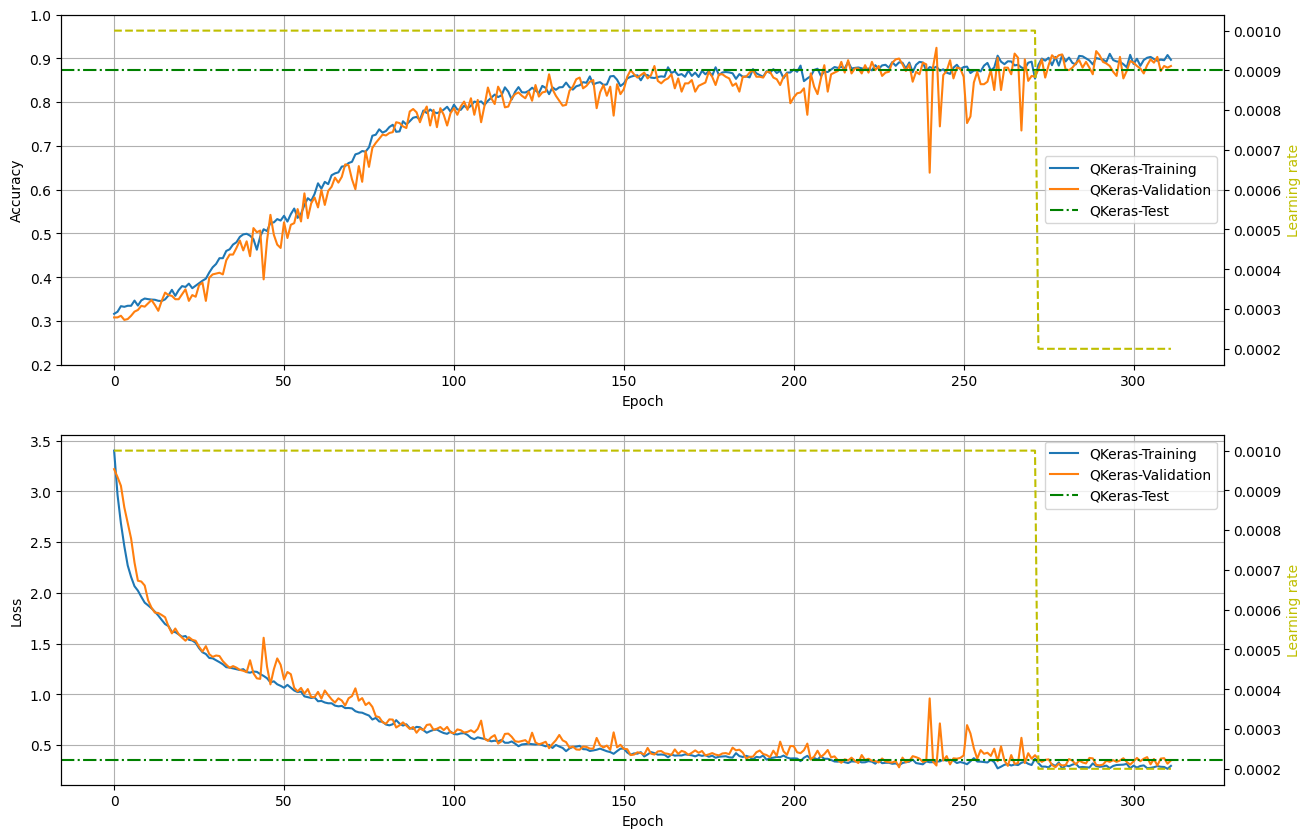

In [13]:
# learning curves
# plot diagnostic learning curves
import sys
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# Accuracy plot
ax2 = ax[0].twinx()
ax[0].plot(history_qkeras.history['accuracy'], label='QKeras-Training')
ax[0].plot(history_qkeras.history['val_accuracy'], label='QKeras-Validation')
ax[0].axhline(y=test_acc, xmin=0, xmax=epochs, linestyle='-.', color='g', label='QKeras-Test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([1/num_speakers, 1])
ax2.plot(history_qkeras.history['lr'], color='y', linestyle='--')
ax2.set_ylabel('Learning rate', color='y')
ax[0].legend(loc='right')
ax[0].grid()

# Loss plot
ax3 = ax[1].twinx()
ax[1].plot(history_qkeras.history['loss'], label='QKeras-Training')
ax[1].plot(history_qkeras.history['val_loss'], label='QKeras-Validation')
ax[1].axhline(y=test_loss, xmin=0, xmax=epochs, linestyle='-.', color='g', label='QKeras-Test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax3.plot(history_qkeras.history['lr'], color='y', linestyle='--')
ax3.set_ylabel('Learning rate', color='y')
ax[1].legend(loc='upper right')
ax[1].grid()


plt.savefig(path_figures + 'qkeras_acc_loss_epochs.png')
plt.show()

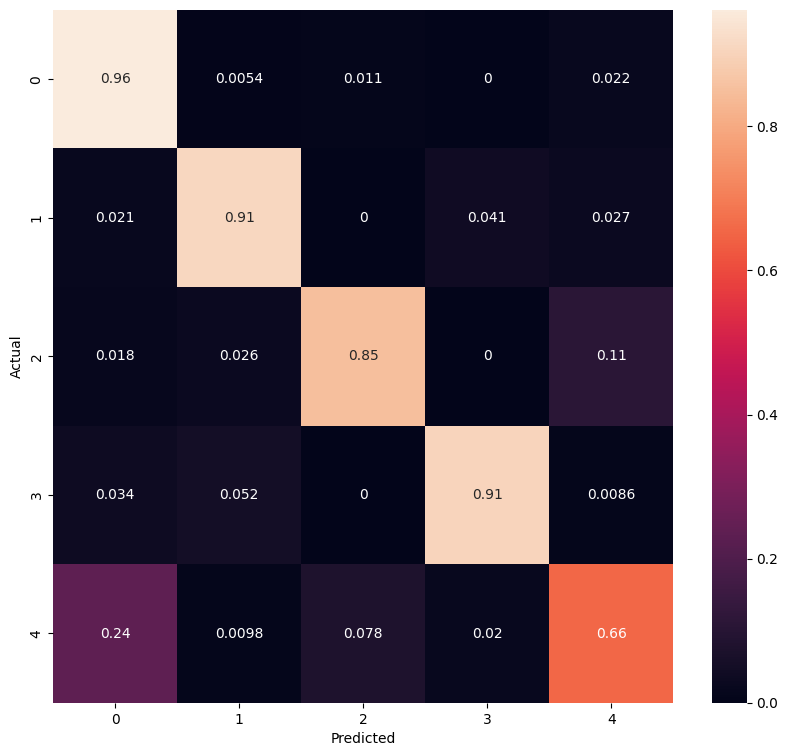

In [14]:
y_pred_hard = np.argmax(y_pred, axis=1)
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, y_pred_hard, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(path_figures + 'qkeras_cm.png')
plt.show()

In [15]:
h5_in_kb = os.path.getsize(path_qkeras_model+model_name_qkeras) / 1024
print("Keras model file : ", model_name_qkeras)
print("HDF5 Keras Model size: %d KB" % h5_in_kb)

Keras model file :  qkeras_test_5_spk.h5
HDF5 Keras Model size: 1299 KB


# QKeras Bias

In [16]:
from models import get_qmodel
qmodel_biased = get_qmodel(train_set.shape, num_speakers, biased=True)
qmodel_biased.build(input_shape=train_set.shape)

qmodel_biased.summary()
print_qstats(qmodel_biased)

c:\Users\kerem\anaconda3\envs\ml_mcu_env\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (2644, 171, 13, 1)       3         
 ion)                                                            
                                                                 
 conv2d_1 (QConv2D)          (2644, 171, 13, 16)       160       
                                                                 
 batch_normalization_4 (Batc  (2644, 171, 13, 16)      64        
 hNormalization)                                                 
                                                                 
 act_1 (QActivation)         (2644, 171, 13, 16)       0         
                                                                 
 conv2d_2 (QConv2D)          (2644, 86, 7, 32)         4640      
                                                                 
 batch_normalization_5 (Batc  (2644, 86, 7, 32)       

In [17]:
from contextlib import redirect_stdout

with open(model_dir_root + 'qkeras_biased_summary.txt', 'w') as f:
    with redirect_stdout(f):
        qmodel_biased.summary()
        print_qstats(qmodel_biased)

In [18]:
batchSize = 64 #8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 500 #40 # nb of back propagations
loss_fct = 'sparse_categorical_crossentropy'

In [19]:
qmodel_biased.compile(
    loss=loss_fct, 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(path_qkeras_biased_model + model_name_biased_qkeras, 
                                    save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=40, min_lr=1.0e-5,verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=80, verbose=1),       
]

history_qkeras = qmodel_biased.fit(x=train_set, 
                                   y=y_train, 
                                   batch_size=batchSize, 
                                   epochs=epochs, 
                                   validation_split=0.2,
                                   callbacks = callbacks)

Epoch 1/500
34/34 [==============================] - 5s 60ms/step - loss: 5.6805 - accuracy: 0.1830 - val_loss: 6.5361 - val_accuracy: 0.1739 - lr: 0.0010
Epoch 2/500
34/34 [==============================] - 1s 27ms/step - loss: 5.3282 - accuracy: 0.1806 - val_loss: 6.3923 - val_accuracy: 0.1739 - lr: 0.0010
Epoch 3/500
34/34 [==============================] - 1s 26ms/step - loss: 4.9522 - accuracy: 0.1915 - val_loss: 5.9718 - val_accuracy: 0.1739 - lr: 0.0010
Epoch 4/500
34/34 [==============================] - 1s 27ms/step - loss: 4.6231 - accuracy: 0.2052 - val_loss: 5.4226 - val_accuracy: 0.1796 - lr: 0.0010
Epoch 5/500
34/34 [==============================] - 1s 24ms/step - loss: 4.3751 - accuracy: 0.1901 - val_loss: 4.9412 - val_accuracy: 0.1796 - lr: 0.0010
Epoch 6/500
34/34 [==============================] - 1s 25ms/step - loss: 4.1004 - accuracy: 0.1943 - val_loss: 4.5821 - val_accuracy: 0.1834 - lr: 0.0010
Epoch 7/500
34/34 [==============================] - 1s 27ms/step - lo

In [20]:
import qkeras
qmodel_biased = qkeras.utils.load_qmodel(path_qkeras_biased_model + model_name_biased_qkeras)
y_pred = qmodel_biased.predict(test_set)

test_loss_b, test_acc_b = qmodel_biased.evaluate(test_set,  y_test, verbose=1)
print('Test accuracy:', test_acc_b)
print('Test loss:', test_loss_b)

21/21 [==============================] - 0s 3ms/step - loss: 0.2675 - accuracy: 0.8958
Test accuracy: 0.8957703709602356
Test loss: 0.2675453722476959


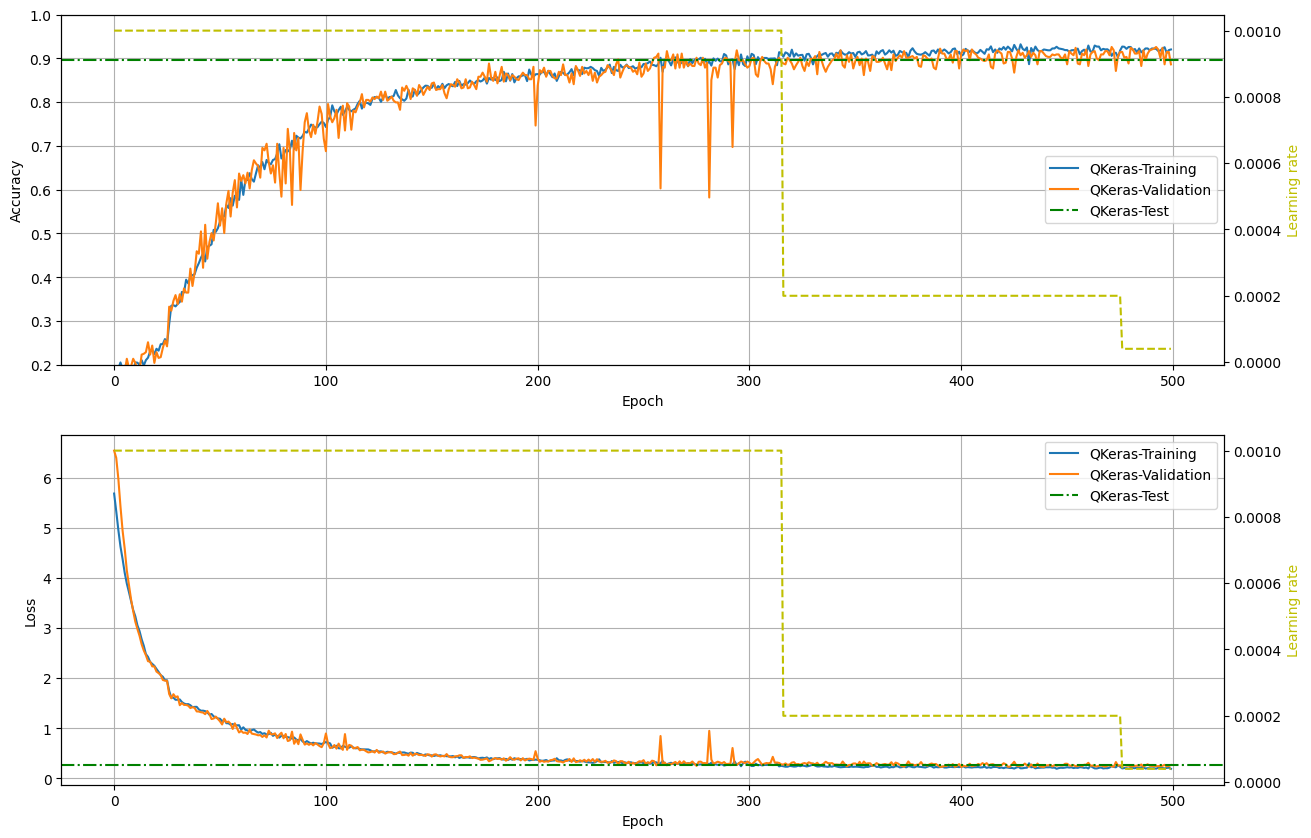

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# Accuracy plot
ax2 = ax[0].twinx()
ax[0].plot(history_qkeras.history['accuracy'], label='QKeras-Training')
ax[0].plot(history_qkeras.history['val_accuracy'], label='QKeras-Validation')
ax[0].axhline(y=test_acc_b, xmin=0, xmax=epochs, linestyle='-.', color='g', label='QKeras-Test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([1/num_speakers, 1])
ax2.plot(history_qkeras.history['lr'], color='y', linestyle='--')
ax2.set_ylabel('Learning rate', color='y')
ax[0].legend(loc='right')
ax[0].grid()

# Loss plot
ax3 = ax[1].twinx()
ax[1].plot(history_qkeras.history['loss'], label='QKeras-Training')
ax[1].plot(history_qkeras.history['val_loss'], label='QKeras-Validation')
ax[1].axhline(y=test_loss_b, xmin=0, xmax=epochs, linestyle='-.', color='g', label='QKeras-Test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax3.plot(history_qkeras.history['lr'], color='y', linestyle='--')
ax3.set_ylabel('Learning rate', color='y')
ax[1].legend(loc='upper right')
ax[1].grid()


plt.savefig(path_figures + 'qkeras_biased_acc_loss_epochs.png')
plt.show()

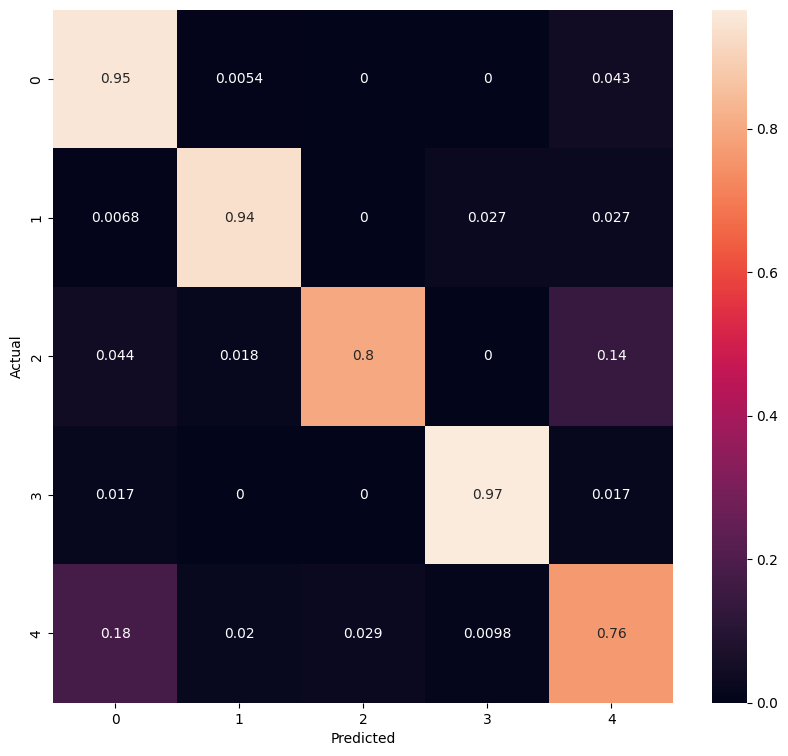

In [22]:
y_pred_hard = np.argmax(y_pred, axis=1)
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, y_pred_hard, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(path_figures + 'qkeras_biased_cm.png')
plt.show()

# TF Lite Conversion and Quantization:
Attention the below part is wrong because I quantize again in the TFLite conversion step !

In [23]:
tflite_qkeras_q, sizes_on_disk_qkeras, comp_rats_qkeras, legends_qkeras = \
    convert_to_tf_lite(path_keras_model=path_qkeras_model + model_name_qkeras, 
                       train_set=train_set, 
                       path_tf_lite_q_model=path_qkeras_model + model_name_tf_lite_qkeras,
                       is_qkeras=True)
    
tflite_qkeras_b_q, sizes_on_disk_qkeras_b, comp_rats_qkeras_b, legends_qkeras_b = \
    convert_to_tf_lite(path_keras_model=path_qkeras_biased_model + model_name_biased_qkeras, 
                       train_set=train_set, 
                       path_tf_lite_q_model=path_qkeras_biased_model + model_name_tf_lite_biased_qkeras,
                       is_qkeras=True)
    
sizes_on_disk = sizes_on_disk_qkeras.extend(sizes_on_disk_qkeras_b[-2:])
comp_rats = comp_rats_qkeras.extend(comp_rats_qkeras_b[-2:])
legends = ["QKeras", "TFLiteQKeras", "QKerasBiased", "TFLiteQKerasBiased"]

c:\Users\kerem\anaconda3\envs\ml_mcu_env\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmp753ss4_s\assets


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmp753ss4_s\assets
c:\Users\kerem\anaconda3\envs\ml_mcu_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


HDF5 Model size without quantization: 1299 KB
Quantized TFLite Model size: 132 KB

Reduction in model size from Keras to TFLiteQuantized by a factor of 9.803619


c:\Users\kerem\anaconda3\envs\ml_mcu_env\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmpkqa3gq0_\assets


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmpkqa3gq0_\assets
c:\Users\kerem\anaconda3\envs\ml_mcu_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


HDF5 Model size without quantization: 1310 KB
Quantized TFLite Model size: 133 KB

Reduction in model size from Keras to TFLiteQuantized by a factor of 9.818773


In [24]:
pred_non_b = eval_tf_lite_model(path_tf_lite_model=path_qkeras_model + model_name_tf_lite_qkeras,
                                test_set=test_set, 
                                quantized=True)

pred_b = eval_tf_lite_model(path_tf_lite_model=path_qkeras_biased_model + model_name_tf_lite_biased_qkeras,
                                test_set=test_set, 
                                quantized=True)

Evaluated model:  ./Models/test_5_spk/QKerasModels/tfflite_qkeras_test_5_spk.tflite
Input shape is [  1 171  13   1] and of type <class 'numpy.int8'>
Output shape is [1 5] and of type <class 'numpy.int8'>
Evaluated model:  ./Models/test_5_spk/Biased_QKerasModels/tfflite_biased_qkeras_test_5_spk.tflite
Input shape is [  1 171  13   1] and of type <class 'numpy.int8'>
Output shape is [1 5] and of type <class 'numpy.int8'>


In [25]:
tflite_score_non_b = accuracy_score(y_test, pred_non_b)
print("Accuracy of quantized to int8 qkeras tflite model is {}%".format(tflite_score_non_b*100))
print("Compared to float32 accuracy of {}%".format(test_acc*100))
print("We have a change of {}%".format((tflite_score_non_b-test_acc)*100))

tflite_score_b = accuracy_score(y_test, pred_b)
print("Accuracy of quantized to int8 biased qkeras tflite model is {}%".format(tflite_score_b*100))
print("Compared to float32 accuracy of {}%".format(test_acc*100))
print("We have a change of {}%".format((tflite_score_b-test_acc)*100))

Accuracy of quantized to int8 qkeras tflite model is 31.87311178247734%
Compared to float32 accuracy of 87.46223449707031%
We have a change of -55.589122714592975%
Accuracy of quantized to int8 biased qkeras tflite model is 50.755287009063444%
Compared to float32 accuracy of 87.46223449707031%
We have a change of -36.70694748800687%


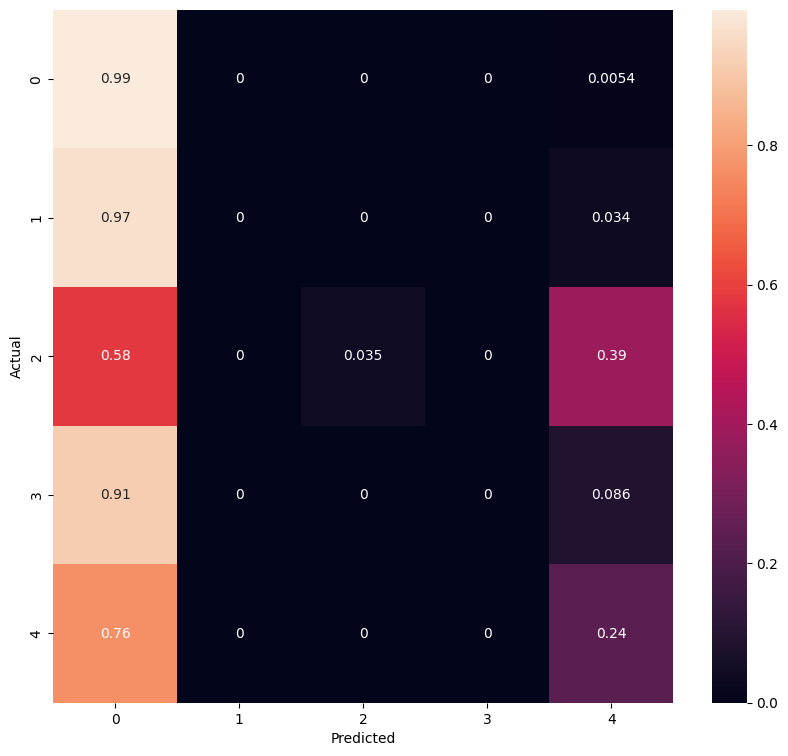

In [26]:
plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, pred_non_b, 
                      normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(path_figures + 'tflite_q_cm.png')
plt.show()

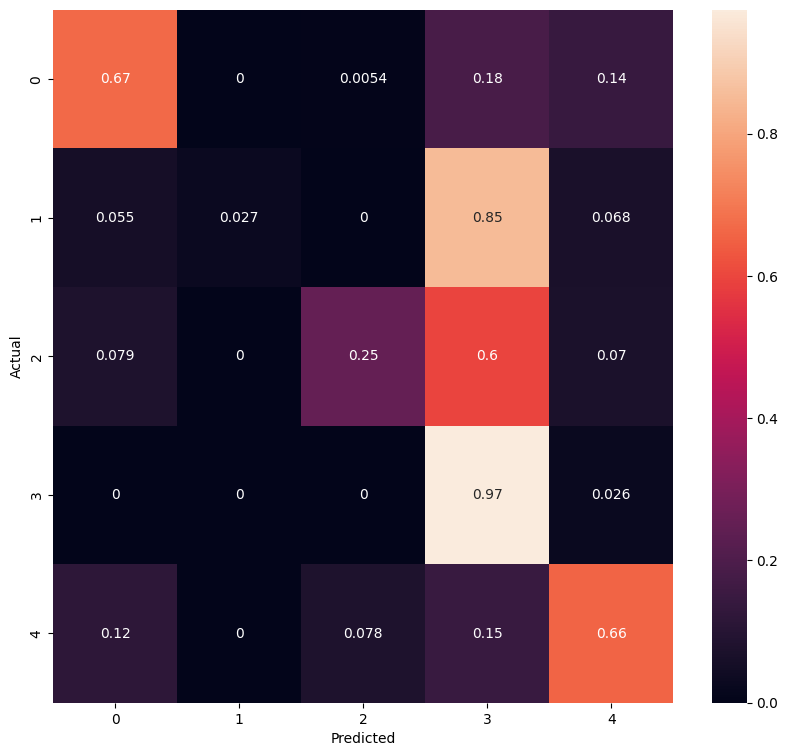

In [27]:
plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, pred_b, 
                      normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(path_figures + 'tflite_q_cm.png')
plt.show()

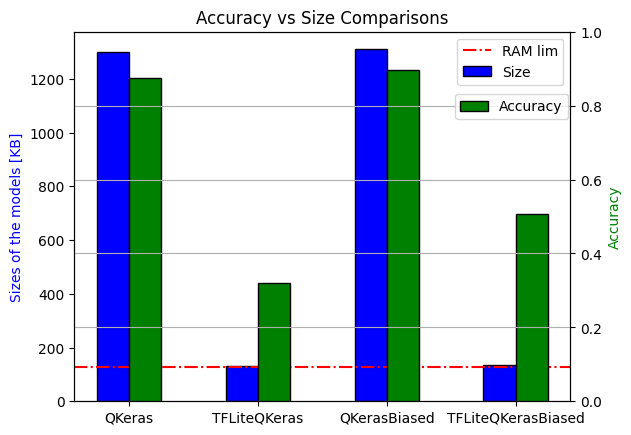

In [28]:
mcu_ram_lim = 128

# Plots for comparison
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
width=0.25
x_ax_tmp = np.arange(len(legends))

ax1.bar(x_ax_tmp, sizes_on_disk_qkeras, color='b', width=width, edgecolor='k', label='Size')
ax1.set_ylabel("Sizes of the models [KB]", color='b')
ax1.axhline(y=mcu_ram_lim, xmin=0., xmax=len(legends), linestyle='-.', color='r', label='RAM lim')
ax1.legend(loc='upper right',  bbox_to_anchor=(1, 1))

ax2.bar(x_ax_tmp+width, [test_acc, tflite_score_non_b, test_acc_b, tflite_score_b], 
        color='g', width=width, edgecolor='k', label='Accuracy')
ax2.set_ylabel("Accuracy", color='g')
ax2.set_ylim([0., 1.])
ax2.legend(loc='upper right',  bbox_to_anchor=(1.01, 0.85))

plt.grid()
plt.title("Accuracy vs Size Comparisons")
plt.xticks(x_ax_tmp+width/2, legends)
plt.savefig(path_figures + 'acc_comps_qkeras_biased.png')
plt.show()